<a href="https://www.kaggle.com/code/yaaaaam1/yolov8n-rider-with-without-helmet?scriptVersionId=174409108" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Basic Learning About YOLO Dataset

### What does YOLO dataset format look like?
```
 data_directory/
    ├── images/
    │   ├── image1.jpg
    │   ├── image2.jpg
    │   ├── ...
    │   └── imageN.jpg
    └── labels/
        ├── image1.txt
        ├── image2.txt
        ├── ...
        └── imageN.txt 


```


### What does label data look like?
```
2 0.561805 0.503788 0.865275 0.983333
0 0.569729 0.083333 0.310611 0.139394
3 0.477813 0.838636 0.329628 0.089394
```

- a row --> an object detecting in this image
- the meaning of each element within each row:
    - label 
    - the bounding box middle point x 
    - the bounding box middle point y
    - the bounding box width
    - the bounding box heigth




# Check GPU Setting
Remember to click Accelerator to activate GPU for the model training, and the you may use `nvydia-smi` to check current status of GPU

In [1]:
! nvidia-smi

Sun Apr 28 07:27:04 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Install Needed Packages

In [2]:
# install packages used in YOLO model
! pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.6/40.6 kB 625.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 752.1/752.1 kB 5.8 MB/s eta 0:00:00


In [3]:
# check model
import ultralytics
ultralytics.checks() 

Ultralytics YOLOv8.2.4 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (4 CPUs, 31.4 GB RAM, 5597.6/8062.4 GB disk)


# Data Analytics - EDA
Let's take a look at the overall data pattern for further model training

### Get Data Size, Class Count

In [4]:
from glob import glob
from itertools import chain
from collections import Counter
from pprint import pprint

id2class_map = {
    '0': 'with helmet', 
    '1': 'without helmet', 
    '2': 'rider', 
    '3': 'number_plate'
}
main_path = "/kaggle/input/rider-with-helmet-without-helmet-number-plate"  

def print_data_size(folder_type):
    data_size = len(glob(f'{main_path}/{folder_type}/labels/*.txt'))
    print(f'{folder_type} data count: {data_size}')
    
def print_class_count(folder_type):
    class_list = []
    for file in glob(f'{main_path}/{folder_type}/labels/*.txt'):
        class_list.append([row.split()[0] for row in open(file, "r")])
    counter = Counter(list(chain(*class_list)))
    print(f'-- data class count')
    pprint({f'{k}. {id2class_map[k]}':v for k, v in counter.items()})
    print()

print_data_size('train')
print_class_count('train')
print_data_size('val')
print_class_count('val')  

train data count: 104
-- data class count
{'0. with helmet': 64,
 '1. without helmet': 93,
 '2. rider': 120,
 '3. number_plate': 116}

val data count: 20
-- data class count
{'0. with helmet': 13,
 '1. without helmet': 15,
 '2. rider': 23,
 '3. number_plate': 22}



### Plot Training Images

In [5]:
# plot training images
import os
import cv2
from matplotlib import pyplot as plt

main_path = f"/kaggle/input/rider-with-helmet-without-helmet-number-plate"  

def get_bbox_and_label(image_name, data_type='train', main_path=main_path):
    ''' get bbox and label information from label txt files '''
    
    # read file from path
    lbl_path = os.path.join(main_path, data_type, 'labels', f'{image_name}.txt')
    with open(lbl_path, 'r') as f:
        lines = f.readlines()
    
    # extract bboxes and labels from the label file
    bboxes = [
        [float(n) for n in line.split()[1:]]
        for line in lines
    ]
    labels = [id2class_map[line.split()[0]] for line in lines]
    
    return bboxes, labels
    
def load_image(image_name, data_type='train', main_path=main_path):
    img_path = os.path.join(main_path, data_type, 'images', f'{image_name}.jpg')    
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

def get_bbox_coordinates(img, bbox):
    # reference
    # https://medium.com/@miramnair/yolov7-calculating-the-bounding-box-coordinates-8bab54b97924
    
    img_height, img_width, _ = img.shape
    x_center, y_center, bbox_width, bbox_height = bbox
    
    # calculate the coordinates of the bounding box
    x_center_pixel = x_center * img_width
    y_center_pixel = y_center * img_height
    half_width = bbox_width * img_width / 2
    half_height = bbox_height * img_height / 2
    
    x_min = int(x_center_pixel - half_width)
    y_min = int(y_center_pixel - half_height)
    x_max = int(x_center_pixel + half_width)
    y_max = int(y_center_pixel + half_height)
    
    return x_min, y_min, x_max, y_max

class2color_map = {
    'with helmet': (0,255,128),
    'without helmet': (255,51,51),
    'rider': (51,255,255),
    'number_plate': (224,102,255)
}

def plot_image(image_name, data_type='train', class2color_map=class2color_map):
    img = load_image(image_name=image_name, data_type=data_type)
    bboxes, labels = get_bbox_and_label(image_name=image_name, data_type=data_type)
    for bbox, label in zip(bboxes, labels):
        
        # get bbox and label info
        color = class2color_map[label]
        x_min, y_min, x_max, y_max = get_bbox_coordinates(img, bbox)
        
        # add bounding box with rectangle
        img = cv2.rectangle(img,(x_min,y_min),(x_max,y_max), color, 2)
        
        # add label info
        img = cv2.putText(
                img,
                label,
                (x_min, y_min + 10),
                fontFace = cv2.FONT_HERSHEY_SIMPLEX,
                fontScale = 0.6,
                color = color,
                thickness=2
            )
    plt.imshow(img)
    plt.show()

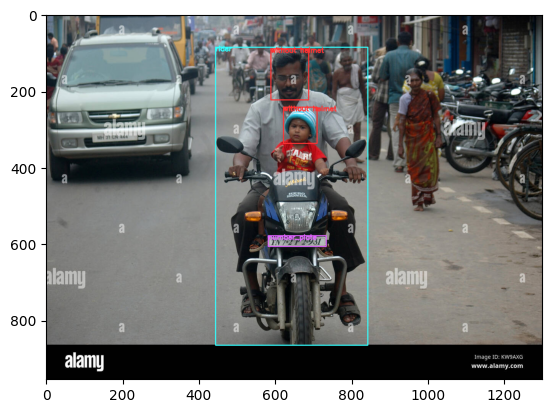

In [6]:
plot_image(image_name='new100')

# Load YOLO8 Model

In [7]:
from ultralytics import YOLO

# Load a COCO-pretrained YOLOv8n model
model = YOLO('yolov8n.pt')

# Display model information (optional)
model.info()

100%|██████████| 6.23M/6.23M [00:00<00:00, 75.4MB/s]


YOLOv8n summary: 225 layers, 3157200 parameters, 0 gradients, 8.9 GFLOPs


(225, 3157200, 0, 8.8575488)

# Set yaml & Model Training

In [8]:
import yaml

# read the content of coco128.yaml
with open(os.path.join(main_path, 'coco128.yaml'), 'r') as file:
    print(file.read())

train: /train/images
val: /val/images

nc: 4

names: ["with helmet", "without helmet", "rider", "number plate"]


In [9]:
# creata the yaml based on coco128 for model training
data = {
    'train': '/kaggle/input/rider-with-helmet-without-helmet-number-plate/train',
    'val': '/kaggle/input/rider-with-helmet-without-helmet-number-plate/val',
    'nc': 4,
    'names': [
        'with helmet',
        'without helmet',
        'rider',
        'number plate'
    ]
}

with open('/kaggle/working/data.yaml', 'w') as file:
    yaml.dump(data, file)

# check the content of data.yaml
with open('/kaggle/working/data.yaml', 'r') as file:
    print(file.read())

names:
- with helmet
- without helmet
- rider
- number plate
nc: 4
train: /kaggle/input/rider-with-helmet-without-helmet-number-plate/train
val: /kaggle/input/rider-with-helmet-without-helmet-number-plate/val



In [10]:
# disable wandb
os.environ['WANDB_MODE'] = "disabled"


# command to train the YOLOv8 model
model.train(
    data='/kaggle/working/data.yaml',
    epochs=50,
    workers=1,
    batch=8,
)

Ultralytics YOLOv8.2.4 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/kaggle/working/data.yaml, epochs=50, time=None, patience=100, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=1, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=Tru

100%|██████████| 755k/755k [00:00<00:00, 13.7MB/s]
2024-04-28 07:27:38,790	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-04-28 07:27:41,147	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-04-28 07:27:45.365050: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-28 07:27:45.365172: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-28 07:27:45.652227: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS facto

Overriding model.yaml nc=80 with nc=4

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /kaggle/input/rider-with-helmet-without-helmet-number-plate/train/labels... 102 images, 0 backgrounds, 2 corrupt: 100%|██████████| 104/104 [00:00<00:00, 147.35it/s]

train: WARNING ⚠️ /kaggle/input/rider-with-helmet-without-helmet-number-plate/train/images/new128.jpg: ignoring corrupt image/label: cannot identify image file '/kaggle/input/rider-with-helmet-without-helmet-number-plate/train/images/new128.jpg'
train: WARNING ⚠️ /kaggle/input/rider-with-helmet-without-helmet-number-plate/train/images/new3.jpg: ignoring corrupt image/label: invalid image format GIF. Supported formats are:
images: {'tiff', 'jpeg', 'pfm', 'jpg', 'mpo', 'webp', 'tif', 'png', 'dng', 'bmp'}
videos: {'mpg', 'wmv', 'mpeg', 'mov', 'm4v', 'asf', 'mp4', 'mkv', 'ts', 'webm', 'gif', 'avi'}
train: WARNING ⚠️ Cache directory /kaggle/input/rider-with-helmet-without-helmet-number-plate/train is not writeable, cache not saved.


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/input/rider-with-helmet-without-helmet-number-plate/val/labels... 20 images, 0 backgrounds, 0 corrupt: 100%|██████████| 20/20 [00:00<00:00, 142.15it/s]

val: WARNING ⚠️ Cache directory /kaggle/input/rider-with-helmet-without-helmet-number-plate/val is not writeable, cache not saved.


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 1 dataloader workers
Logging results to runs/detect/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      1.22G      1.083      3.444      1.281         53        640: 100%|██████████| 13/13 [00:06<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.03it/s]

                   all         20         73     0.0223      0.399      0.212      0.162



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      1.19G     0.9133      2.491      1.135         32        640: 100%|██████████| 13/13 [00:02<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.20it/s]


                   all         20         73     0.0265      0.457      0.231      0.188

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      1.19G     0.8872      1.588      1.127         43        640: 100%|██████████| 13/13 [00:02<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.56it/s]

                   all         20         73     0.0588      0.906      0.659      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      1.19G      0.899      1.333      1.097         50        640: 100%|██████████| 13/13 [00:02<00:00,  5.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.33it/s]


                   all         20         73      0.883      0.286      0.749      0.554

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50       1.2G     0.9131      1.287      1.102         55        640: 100%|██████████| 13/13 [00:02<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.84it/s]

                   all         20         73      0.936      0.472      0.832      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      1.19G     0.8559       1.17      1.061         55        640: 100%|██████████| 13/13 [00:02<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.65it/s]

                   all         20         73      0.824       0.56      0.862      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      1.19G     0.8672      1.176       1.09         34        640: 100%|██████████| 13/13 [00:02<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.53it/s]


                   all         20         73      0.809      0.657      0.832      0.606

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      1.19G     0.8563      1.102      1.073         43        640: 100%|██████████| 13/13 [00:02<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.57it/s]


                   all         20         73      0.721       0.66      0.856      0.644

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      1.19G     0.8638      1.044       1.07         61        640: 100%|██████████| 13/13 [00:02<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.19it/s]


                   all         20         73      0.713      0.747      0.902      0.666

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      1.19G     0.8396      1.012      1.042         51        640: 100%|██████████| 13/13 [00:02<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.45it/s]


                   all         20         73      0.728       0.71      0.887      0.654

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      1.19G     0.8788      1.032      1.087         35        640: 100%|██████████| 13/13 [00:02<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.10it/s]


                   all         20         73      0.797      0.772      0.897      0.642

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      1.19G     0.8271     0.9982      1.078         39        640: 100%|██████████| 13/13 [00:02<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.90it/s]

                   all         20         73      0.788       0.89      0.906      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      1.19G     0.8168     0.9789      1.058         48        640: 100%|██████████| 13/13 [00:02<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.97it/s]

                   all         20         73      0.854        0.9      0.923      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      1.19G     0.8047     0.9424      1.029         41        640: 100%|██████████| 13/13 [00:02<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.68it/s]

                   all         20         73        0.9      0.898      0.924        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      1.19G     0.7972     0.9388      1.031         62        640: 100%|██████████| 13/13 [00:02<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.80it/s]

                   all         20         73      0.893      0.877      0.936      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      1.19G       0.78     0.8734      1.025         40        640: 100%|██████████| 13/13 [00:02<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.87it/s]


                   all         20         73       0.91       0.88      0.941      0.734

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      1.19G     0.7881      0.897      1.043         48        640: 100%|██████████| 13/13 [00:02<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.84it/s]

                   all         20         73      0.844       0.87      0.922      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      1.19G     0.7994     0.8968      1.032         28        640: 100%|██████████| 13/13 [00:02<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.67it/s]

                   all         20         73      0.902      0.824      0.934      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      1.19G     0.7972     0.8917      1.055         47        640: 100%|██████████| 13/13 [00:02<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.23it/s]


                   all         20         73      0.929      0.817      0.929      0.685

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      1.19G     0.7836     0.8819      1.038         37        640: 100%|██████████| 13/13 [00:02<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.61it/s]

                   all         20         73      0.898      0.868      0.923      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      1.19G      0.749     0.8413      1.033         49        640: 100%|██████████| 13/13 [00:02<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.85it/s]

                   all         20         73      0.851      0.899      0.914      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      1.19G     0.7599     0.8564      1.018         52        640: 100%|██████████| 13/13 [00:02<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.71it/s]

                   all         20         73      0.915      0.834      0.917      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      1.19G     0.7434     0.8313      1.016         50        640: 100%|██████████| 13/13 [00:02<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.32it/s]


                   all         20         73      0.881      0.899      0.931      0.717

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      1.19G     0.7933      0.835      1.043         44        640: 100%|██████████| 13/13 [00:02<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.53it/s]


                   all         20         73      0.901      0.888      0.937      0.731

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      1.19G     0.7292     0.7789      0.993         51        640: 100%|██████████| 13/13 [00:02<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.24it/s]


                   all         20         73      0.911      0.929      0.941       0.75

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      1.19G     0.7167     0.7642      1.008         40        640: 100%|██████████| 13/13 [00:02<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.60it/s]


                   all         20         73      0.942      0.885      0.939      0.757

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      1.19G     0.7132     0.7669     0.9951         35        640: 100%|██████████| 13/13 [00:02<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.13it/s]

                   all         20         73      0.885      0.911      0.932      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      1.19G      0.706     0.7542     0.9904         57        640: 100%|██████████| 13/13 [00:02<00:00,  5.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.92it/s]

                   all         20         73      0.916      0.872      0.932      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      1.19G     0.6854     0.7347     0.9872         50        640: 100%|██████████| 13/13 [00:02<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.69it/s]

                   all         20         73      0.915      0.906      0.935      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50       1.2G     0.6758     0.7287     0.9761         41        640: 100%|██████████| 13/13 [00:02<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.57it/s]

                   all         20         73      0.938      0.927       0.94      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      1.19G     0.6926     0.7207     0.9796         49        640: 100%|██████████| 13/13 [00:02<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.47it/s]


                   all         20         73      0.923      0.934      0.945      0.756

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      1.19G     0.6993     0.7189      1.005         32        640: 100%|██████████| 13/13 [00:02<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.38it/s]


                   all         20         73      0.907      0.941      0.945      0.753

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      1.19G     0.6526     0.7072     0.9722         33        640: 100%|██████████| 13/13 [00:02<00:00,  5.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.90it/s]

                   all         20         73      0.923      0.887      0.936      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      1.19G     0.6513     0.7093     0.9934         57        640: 100%|██████████| 13/13 [00:02<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.29it/s]


                   all         20         73      0.896      0.909      0.933      0.746

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      1.19G     0.6665     0.6975     0.9918         52        640: 100%|██████████| 13/13 [00:02<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.87it/s]


                   all         20         73      0.887      0.917      0.908      0.707

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      1.19G     0.6776     0.6885      0.984         50        640: 100%|██████████| 13/13 [00:02<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.55it/s]


                   all         20         73      0.885      0.909        0.9      0.721

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      1.19G     0.6501      0.691     0.9665         43        640: 100%|██████████| 13/13 [00:02<00:00,  5.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.26it/s]

                   all         20         73      0.896      0.908      0.898      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      1.19G     0.6156     0.6598     0.9887         50        640: 100%|██████████| 13/13 [00:02<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.72it/s]


                   all         20         73      0.919      0.878      0.916      0.747

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      1.19G     0.6179     0.6525     0.9748         42        640: 100%|██████████| 13/13 [00:02<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.74it/s]


                   all         20         73      0.939      0.885      0.935       0.75

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      1.19G     0.6211     0.6472     0.9643         49        640: 100%|██████████| 13/13 [00:02<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.76it/s]

                   all         20         73      0.967      0.887      0.938       0.76


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      1.19G     0.5796     0.8476      0.937         23        640: 100%|██████████| 13/13 [00:03<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.64it/s]

                   all         20         73      0.959       0.89       0.93      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      1.19G     0.5831     0.7917     0.9216         22        640: 100%|██████████| 13/13 [00:02<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.41it/s]


                   all         20         73      0.945      0.889      0.928       0.75

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      1.19G     0.5669     0.7835     0.9035         31        640: 100%|██████████| 13/13 [00:02<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.68it/s]


                   all         20         73      0.898      0.923      0.932      0.752

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      1.19G     0.5933     0.8034     0.9067         18        640: 100%|██████████| 13/13 [00:02<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.98it/s]

                   all         20         73      0.905      0.923      0.929      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      1.19G      0.561     0.7349     0.9002         19        640: 100%|██████████| 13/13 [00:02<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.80it/s]

                   all         20         73      0.921      0.904      0.936      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      1.19G     0.5528       0.71     0.8914         20        640: 100%|██████████| 13/13 [00:02<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.18it/s]


                   all         20         73      0.916      0.903      0.942      0.747

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      1.19G     0.5391     0.6808     0.8872         22        640: 100%|██████████| 13/13 [00:02<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.43it/s]


                   all         20         73      0.929      0.882      0.943      0.746

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      1.19G     0.5508     0.6867     0.8966         20        640: 100%|██████████| 13/13 [00:02<00:00,  5.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.83it/s]

                   all         20         73      0.926      0.882      0.939      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      1.19G     0.5493     0.6742     0.9021         19        640: 100%|██████████| 13/13 [00:02<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.92it/s]


                   all         20         73      0.911      0.896      0.939      0.752

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      1.19G     0.5303     0.6764     0.9043         17        640: 100%|██████████| 13/13 [00:02<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.16it/s]


                   all         20         73      0.912      0.896      0.939      0.759

50 epochs completed in 0.056 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.2.4 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3006428 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.13it/s]


                   all         20         73      0.967      0.887      0.938      0.757
           with helmet         20         13      0.896      0.846      0.882      0.658
        without helmet         20         15          1      0.788      0.929      0.769
                 rider         20         23       0.98      0.913      0.944      0.829
          number plate         20         22      0.993          1      0.995      0.772
Speed: 0.2ms preprocess, 3.3ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x79c0f7d7ff10>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0

# Check Val Detecting Image
We may check the detection result of our validation images.

In [11]:
# select the best model for checking prediction plot
# the model is saved in best.pt directly after training
model = YOLO('/kaggle/working/runs/detect/train/weights/best.pt')

In [12]:
# use results from `model.predict()` for plotting 
def plot_pred_image(image_name, id2class_map=id2class_map, class2color_map=class2color_map):
    image_path = os.path.join(main_path, 'val', 'images', f'{image_name}.jpg')
    
    # get plot elements (bbox, labels) from `predict()` results
    results = model.predict(image_path)
    r = results[0]
    img = r.orig_img
    bboxes = r.boxes.xyxy.tolist()
    labels = [id2class_map[str(int(c))] for c in r.boxes.cls.tolist()]
    for bbox, label in zip(bboxes, labels):
        # get bbox and label info
        color = class2color_map[label]
        x_min, y_min, x_max, y_max = [int(n) for n in bbox]
        
        # add bounding box with rectangle
        img = cv2.rectangle(img,(x_min,y_min),(x_max,y_max), color, 2)
        
        # add label info
        img = cv2.putText(
                img,
                label,
                (x_min, y_min + 10),
                fontFace = cv2.FONT_HERSHEY_SIMPLEX,
                fontScale = 0.6,
                color = color,
                thickness=2
            )
    plt.imshow(img)
    plt.show()

prediction ↓

image 1/1 /kaggle/input/rider-with-helmet-without-helmet-number-plate/val/images/new94.jpg: 608x640 1 with helmet, 1 rider, 1 number plate, 83.7ms
Speed: 2.8ms preprocess, 83.7ms inference, 1.7ms postprocess per image at shape (1, 3, 608, 640)


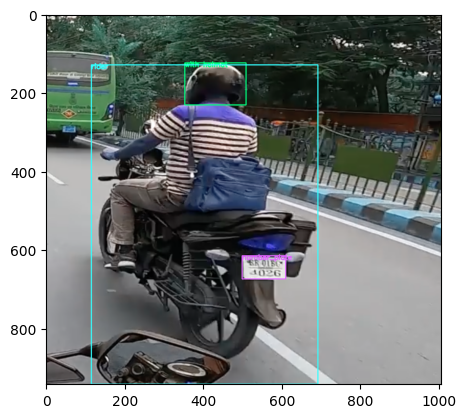

actual image ↓


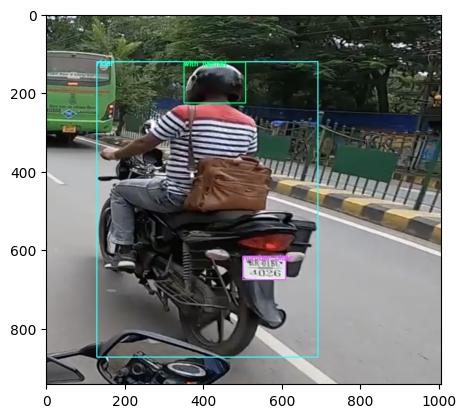

In [13]:
image_name = 'new94'
print('prediction ↓')
plot_pred_image(image_name=image_name)
print('actual image ↓')
plot_image(image_name=image_name, data_type='val')